In [4]:
import cv2
from pylab import *
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
import random
#imports of all the relevant information
dataset = pd.read_csv('/Users/alykhan/Desktop/CharacterModel/input/A_Z Handwritten Data.csv') #Add your path to the dataset
dataset.columns = ['label'] + [f'pixel{i}' for i in range(784)]
dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372445,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372446,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372447,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372448,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


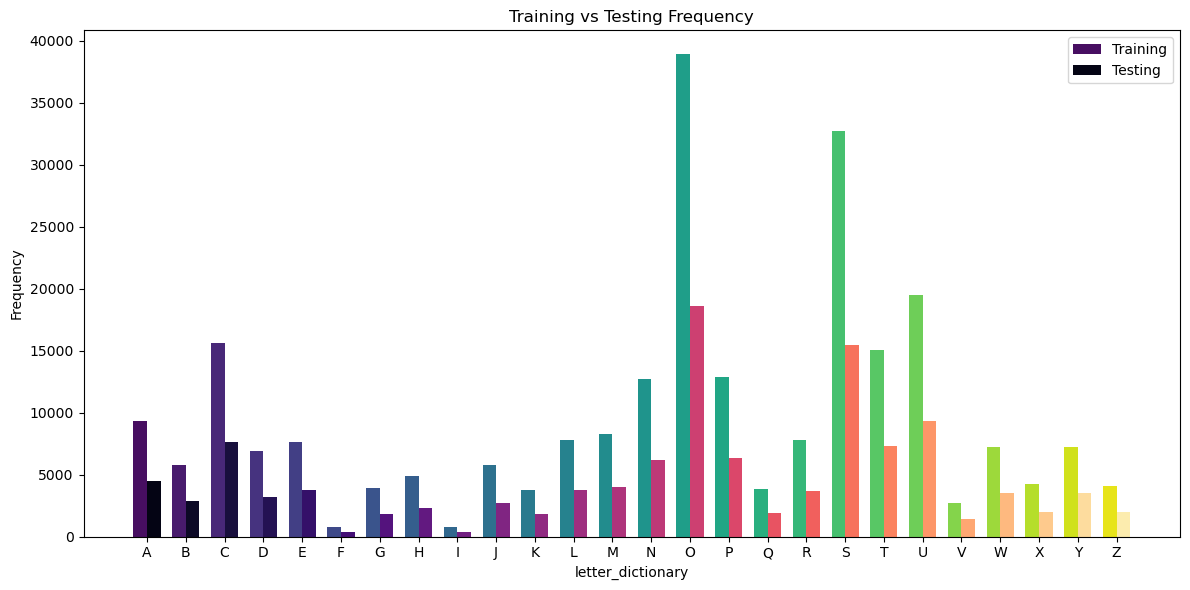

In [10]:
#Shuffles the data randomly
data = data.sample(frac=1).reset_index(drop=True)
#Selects the first 250,000 numbers as the training set
train_set=data.iloc[:250000,:]
#Selects the rest of the data upto the next 120,000 as the test set
test_set=data.iloc[250000:370000,:].reset_index(drop=True)
#Creates a dictionary of the letters that will be used as labels
letter_dictionary = [chr(x) for x in range(65, 91)] 

#Creating a Combined Plot to display the training vs testing frequency of the different letters
train_counts = train_set['label'].value_counts().sort_index()
test_counts = test_set['label'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = range(len(letter_dictionary))

bar1 = ax.bar(index, train_counts, bar_width, label='Training', color=sns.color_palette('viridis', 26))
bar2 = ax.bar([i + bar_width for i in index], test_counts, bar_width, label='Testing', color=sns.color_palette('magma', 26))

ax.set_title('Training vs Testing Frequency')
ax.set_xlabel('letter_dictionary')
ax.set_ylabel('Frequency')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(letter_dictionary)
ax.legend()

plt.tight_layout()
plt.show()

In [40]:
#Drops the Letters from the test and training set.
testchars = test_set.drop('label',axis=1)
testlabel = test_set['label']
trainchars = train_set.drop('label',axis=1)
trainlabel = train_set['label']

In [41]:
#In order for the training to occur, the sets must be reshaped to 28*28 (784 = 28*28) and then normalized
trainchars = trainchars.values.reshape(-1, 28, 28, 1)
trainchars = trainchars / 255.0
testchars = testchars.values.reshape(-1, 28, 28, 1)
testchars = testchars / 255.0
#One-Hot Encoding the characters for clear representation of classes and 
trainlabel = tf.keras.utils.to_categorical(trainlabel, 26)
trainlabel.shape

(250000, 26)

In [44]:
import tensorflow as tf

model = tf.keras.models.Sequential([

    #Increases depth of filters in layers for better recognition of more complex features.
    #Includes Dropout layers that prevent overfitting by randomly setting a fraction of the input units to zero.
    #Added batch normalisation to normalise outputs of layers.
    #Added more neurons to dense layers for better feature learning.
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='Same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='Same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='Same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='Same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(26, activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,446,746 (9.33 MB)

 Trainable params: 2,445,210 (9.33 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [45]:
early_stopping = EarlyStopping(
    min_delta=0.0001,
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True,
)
model.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)
history=model.fit(
    trainchars,trainlabel,
    validation_split=0.2,
    callbacks=[early_stopping],
    batch_size=50,
    epochs=3
)

Epoch 1/3
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 646s 161ms/step - accuracy: 0.8216 - loss: 0.6792 - val_accuracy: 0.9772 - val_loss: 0.0869
Epoch 2/3
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 628s 157ms/step - accuracy: 0.9746 - loss: 0.0935 - val_accuracy: 0.9856 - val_loss: 0.0551
Epoch 3/3
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 640s 160ms/step - accuracy: 0.9799 - loss: 0.0757 - val_accuracy: 0.9883 - val_loss: 0.0449


In [56]:
model.summary()
model.save('modelhandwritingfinal.keras')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,337,168 (27.99 MB)

 Trainable params: 2,445,210 (9.33 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 4,890,422 (18.66 MB)

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy on primary y-axis
color = '#1f77b4'
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Accuracy', color=color, fontsize=14)
ax1.plot(history_df['accuracy'], label='Training Accuracy', color=color, linewidth=2)
ax1.plot(history_df['val_accuracy'], label='Validation Accuracy', color='#2ca02c', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.legend(loc='upper left', fontsize=12)

# Create a secondary y-axis for loss
ax2 = ax1.twinx()
color = '#ff7f0e'
ax2.set_ylabel('Loss', color=color, fontsize=14)
ax2.plot(history_df['loss'], label='Training Loss', color=color, linewidth=2)
ax2.plot(history_df['val_loss'], label='Validation Loss', color='#d62728', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Adds gridlines and format the plot
ax1.grid(True, linestyle='--', alpha=0.7)
ax2.grid(False)  

# Title and layout
fig.suptitle('Training and Validation Metrics', fontsize=16, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust title position

plt.show()

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 75s 20ms/step
1280 Incorrect out of 120000


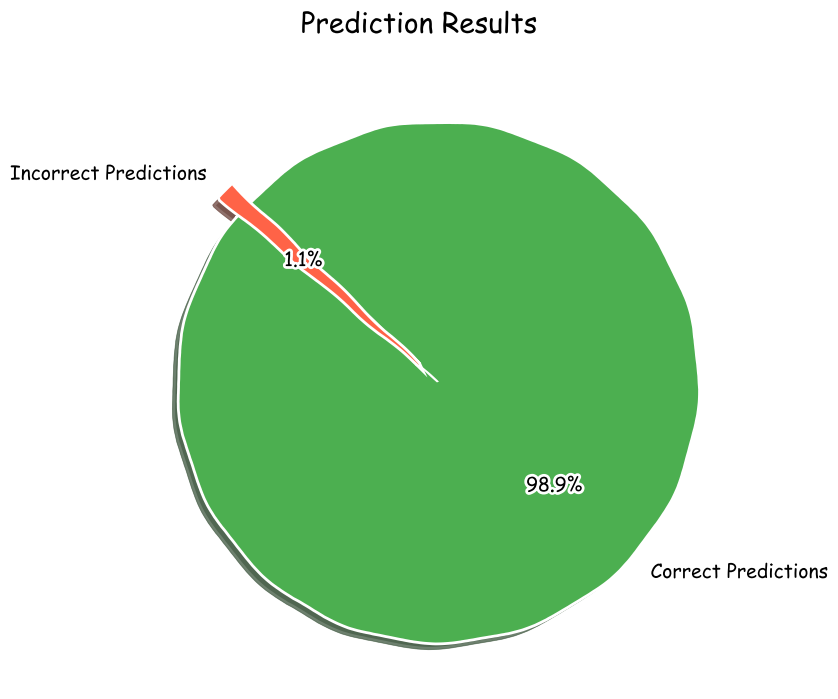

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
result_test = model.predict(testchars)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(result_test, axis=1)

# Convert one-hot encoded true labels to class labels if necessary
true_labels_class = np.argmax(testlabel, axis=1) if len(testlabel.shape) > 1 else testlabel
# Find indices of correct and incorrect predictions
incorrect_predictions = np.where(predicted_labels != true_labels_class)[0]
correct_predictions = np.where(predicted_labels == true_labels_class)[0]

# Print the number of incorrect predictions
print(f"{incorrect_predictions.shape[0]} Incorrect out of {len(true_labels_class)}")

# Calculate the number of correct and incorrect predictions
num_incorrect = incorrect_predictions.shape[0]
num_correct = correct_predictions.shape[0]

# Create data for the pie chart
labels = ['Correct Predictions', 'Incorrect Predictions']
sizes = [num_correct, num_incorrect]
colors = ['#4CAF50', '#FF6347']  # Green for correct, Red for incorrect
explode = (0.1, 0)  # "explode" the correct slice for emphasis

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Prediction Results')
plt.show()


In [ ]:
import numpy as np
from ipycanvas import Canvas
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model


# Dictionary for mapping predictions to characters (example, update accordingly)
word_dictionary = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'
}
model = load_model('modelhandwritingfinal.keras')

class DrawingCanvas:
    def __init__(self, width=280, height=280):
        self.width = width
        self.height = height
        
        # Create the canvas with image data synchronization
        self.canvas = Canvas(width=self.width, height=self.height, sync_image_data=True)
        self.canvas.fill_style = 'white'
        self.canvas.fill_rect(0, 0, self.width, self.height)
        self.drawing = False
        
        # Bind mouse events
        self.canvas.on_mouse_down(self.on_mouse_down)
        self.canvas.on_mouse_move(self.on_mouse_move)
        self.canvas.on_mouse_up(self.on_mouse_up)
        
        # Create buttons
        self.save_button = widgets.Button(description="Save Drawing")
        self.save_button.on_click(self.save_drawing)
        
        self.clear_button = widgets.Button(description="Clear Canvas")
        self.clear_button.on_click(self.clear_canvas)
        
        # Display the canvas and buttons
        display(self.canvas)
        display(self.save_button)
        display(self.clear_button)

    def on_mouse_down(self, x, y):
        self.drawing = True

    def on_mouse_move(self, x, y):
        if self.drawing:
            self.canvas.fill_style = 'black'
            self.canvas.fill_rect(x-4, y-4, 16, 16)  # Thicker pen size

    def on_mouse_up(self, x, y):
        self.drawing = False

    def save_drawing(self, button):
        # Save the drawing as an image
        image_data = self.canvas.get_image_data(0, 0, self.width, self.height)
        data = bytes(image_data.data)  # Convert memoryview to bytes
        image = Image.frombytes('RGBA', (self.width, self.height), data)
        image = image.convert('L')  # Convert to grayscale

        # Resize the image
        image = image.resize((28, 28), Image.ANTIALIAS)
        self.resized_image = np.array(image)  # No need to reshape here
        
        # Invert the image
        self.resized_image = 255 - self.resized_image
        print("Image saved, resized to (28, 28), and inverted.")

        # Display the saved image
        self.display_saved_image()

        # Predict the character
        self.predict_character()

    def clear_canvas(self, button):
        # Clear the canvas
        self.canvas.fill_style = 'white'
        self.canvas.fill_rect(0, 0, self.width, self.height)
        print("Canvas cleared.")

    def display_saved_image(self):
        # Display the saved image using matplotlib with fivethirtyeight and xkcd styles
        plt.style.use('fivethirtyeight')
        plt.xkcd()
        
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(self.resized_image, cmap='gray')
        ax.set_title('Saved Image', fontsize=20, fontweight='bold', color='blue')
        ax.grid(False)
        plt.show()

    def preprocess_image(self):
        # Preprocess the image for prediction
        image = self.resized_image
        image = image / 255.0  # Normalize the image

        # Add channel dimension
        image = np.expand_dims(image, axis=-1)
        
        # Debugging: Show the image with the channel dimension
        print(f"Image shape after adding channel dimension: {image.shape}")
        
        # Add batch dimension
        image = np.expand_dims(image, axis=0)
        
        # Debugging: Show the image with the batch dimension
        print(f"Image shape after adding batch dimension: {image.shape}")
        
        # Debugging: Display the final processed image
        plt.style.use('fivethirtyeight')
        plt.xkcd()
        
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(np.squeeze(image), cmap='gray')
        ax.set_title('Processed Image for Model', fontsize=20, fontweight='bold', color='green')
        ax.grid(False)
        plt.show()
        
        return image

    def predict_character(self):
        # Preprocess the image
        image = self.preprocess_image()
        
        # Predict the character
        prediction = model.predict(image)
        
        # Debugging: Check the raw model output
        print(f"Raw model output: {prediction}")
        
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_char = word_dictionary[predicted_class]
        
        # Display the prediction using matplotlib with fivethirtyeight and xkcd styles
        plt.style.use('fivethirtyeight')
        plt.xkcd()
        
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(self.resized_image, cmap='gray')
        ax.set_title(f"Prediction: {predicted_char}", fontsize=20, fontweight='bold', color='red')
        ax.grid(False)
        plt.show()

# Create and display the drawing canvas
drawing_canvas = DrawingCanvas()